In [156]:
import kagglehub
import shutil
import os

path = kagglehub.dataset_download("veerukhannan/diabetes")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Patryk\.cache\kagglehub\datasets\veerukhannan\diabetes\versions\1


In [157]:
diabetes_path = path
destination = os.path.join(os.getcwd(), 'diabetes')

copy_command = f'powershell -Command "Copy-Item -Path \'{diabetes_path}\' -Destination \'{destination}\' -Recurse"'

result = os.system(copy_command)

if result == 0:
    print(f'Folder został skopiowany do: {destination}')
else:
    print(f'Błąd podczas kopiowania. Kod zakończenia: {result}')
    
new_path = os.path.join(destination)


Błąd podczas kopiowania. Kod zakończenia: 1


In [158]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler


In [168]:
folder_path = './diabetes/1'
all_files = sorted([f for f in os.listdir(folder_path) if f.startswith('data-')])

dfs = []
for file in all_files:
    path = os.path.join(folder_path, file)
    df_part = pd.read_csv(path, sep='\t', header=None)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)
df.columns = ['Date', 'Time', 'Code', 'Value']

print(df.head());
print('Oto wartości z tego datasetu, Code to wartość dozowania insuliny zwracana przez urządzenie');

         Date   Time  Code Value
0  04-21-1991   9:09    58   100
1  04-21-1991   9:09    33     9
2  04-21-1991   9:09    34    13
3  04-21-1991  17:08    62   119
4  04-21-1991  17:08    33     7
Oto wartości z tego datasetu, Code to wartość dozowania insuliny zwracana przez urządzenie


In [169]:
# Naprawa nieprawidłowych wartości:
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')  
df = df.dropna(subset=['Value'])
df['Value'] = df['Value'].astype(int)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=False)
default_date = pd.Timestamp('2000-01-01')
df['Date'] = df['Date'].fillna(default_date)

def fix_time(x):
    try:
        pd.to_datetime(x, format='%H:%M')
        return x
    except:
        return '00:00'

df['Time'] = df['Time'].apply(fix_time)
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'])
df['Code'] = df['Code'].astype(int)
df['Value'] = df['Value'].astype(int)
df = df.sort_values('Datetime')
df.to_csv('clean_diabetes_data.csv', index=False)

print(df.head())

            Date   Time  Code  Value            Datetime
28245 1988-03-27  08:00    58    134 1988-03-27 08:00:00
28246 1988-03-27  08:00    34     20 1988-03-27 08:00:00
28247 1988-03-27  12:00    60    158 1988-03-27 12:00:00
28248 1988-03-27  18:00    62    258 1988-03-27 18:00:00
28249 1988-03-28  08:00    58    115 1988-03-28 08:00:00


In [ ]:

X_reg = df[['Code']]
y_reg = df['Value']

# Podział na zbiór treningowy i testowy
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Model regresji liniowej
regressor = LinearRegression()
regressor.fit(X_reg_train, y_reg_train)

# Predykcje i ocena
y_reg_pred = regressor.predict(X_reg_test)
r2 = r2_score(y_reg_test, y_reg_pred)
print(f'R^2 regresji liniowej: {r2:.3f}')


# Definiujemy etykiety: 1 jeśli Value >= 100, 0 w przeciwnym wypadku
df['Target'] = (df['Value'] >= 100).astype(int)

X_clf = df[['Code']]
y_clf = df['Target']

# Skalowanie cech dla SVM (polecane)
scaler = StandardScaler()
X_clf_scaled = scaler.fit_transform(X_clf)

# Podział na trening i test
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf_scaled, y_clf, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', random_state=42)
clf.fit(X_clf_train, y_clf_train)

y_clf_pred = clf.predict(X_clf_test)
accuracy = accuracy_score(y_clf_test, y_clf_pred)
print(f'Dokładność klasyfikacji SVM: {accuracy:.3f}')

R^2 regresji liniowej: 0.412
Dokładność klasyfikacji SVM: 0.828


In [165]:

# Tabela z porównaniem
regression_df = pd.DataFrame({
    'Code': X_reg_test['Code'].values,
    'Actual': y_reg_test.values,
    'Predicted': y_reg_pred
})
print("\nPorównanie rzeczywistych i przewidywanych wartości (regresja):")
print(regression_df.head())

# Błędy
mae = mean_absolute_error(y_reg_test, y_reg_pred)
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')



Porównanie rzeczywistych i przewidywanych wartości (regresja):
   Code  Actual   Predicted
0    58      97  132.017803
1    57     248  127.454839
2    60     219  141.143730
3    33      10   17.943709
4    58      47  132.017803
MAE: 45.89, MSE: 5174.01, RMSE: 71.93



Porównanie rzeczywistych i przewidywanych etykiet (klasyfikacja):
       Code  Actual  Predicted
0  0.861383       0          1
1  0.786591       1          1
2  1.010969       1          1
3 -1.008435       0          0
4  0.861383       0          1


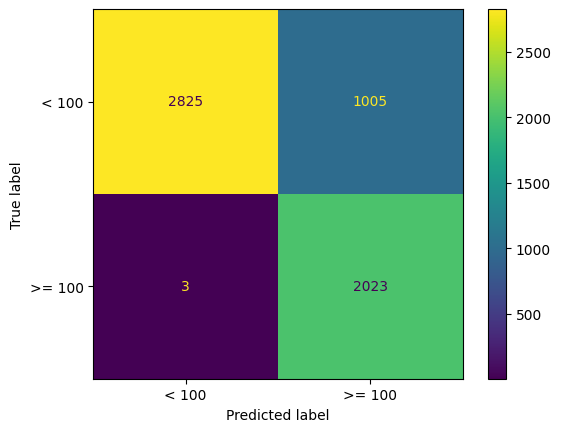

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classification_df = pd.DataFrame({
    'Code': X_clf_test[:, 0],
    'Actual': y_clf_test.values,
    'Predicted': y_clf_pred
})
print("\nPorównanie rzeczywistych i przewidywanych etykiet (klasyfikacja):")
print(classification_df.head())

cm = confusion_matrix(y_clf_test, y_clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['< 100', '>= 100'])
disp.plot()

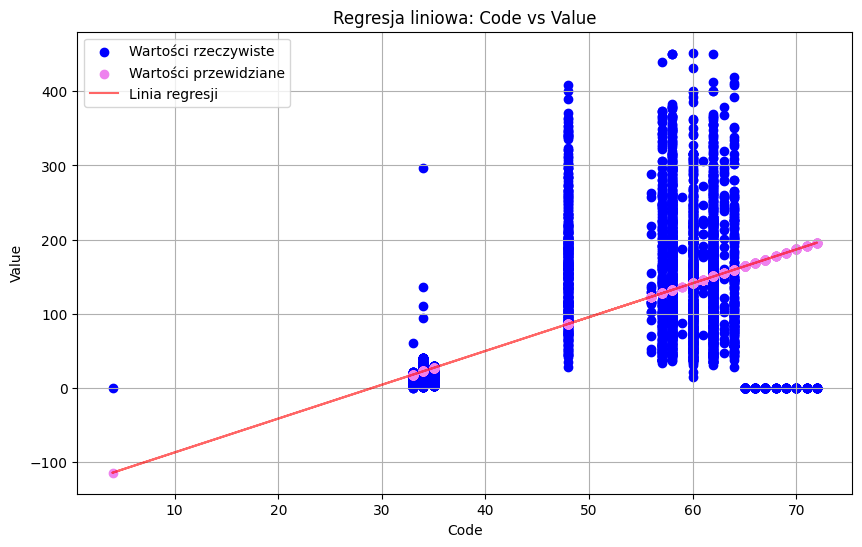

In [167]:
import matplotlib.pyplot as plt

code_for_plot = df.loc[X_reg_test.index, 'Code']

plt.figure(figsize=(10, 6))
plt.scatter(code_for_plot, y_reg_test, color='blue', label='Wartości rzeczywiste')
plt.scatter(code_for_plot, y_reg_pred, color='violet', label='Wartości przewidziane')
plt.plot(code_for_plot, y_reg_pred, color='red', label='Linia regresji', alpha=0.6)

plt.xlabel('Code')
plt.ylabel('Value')
plt.title('Regresja liniowa: Code vs Value')
plt.legend()
plt.grid(True)
plt.show()
